Lab 4: Audio classification, regression and detection
======

In this lab we will analyse audio, make use of the *spectrogram* to convert it to a 2D time-frequency representation, and then applying machine learning.

In the first part of this we use a single audio file. You can download it here:
https://surfdrive.surf.nl/files/index.php/s/DZcHX0YZzoYfkV0

4a: Audio analysis using regression
--

In [1]:
# Import the packages we'll use

import numpy as np
import os, glob, csv

# librosa is a widely-used audio processing library
import librosa

import sklearn

import torch
import torch.nn as nn
import torch.nn.functional as nnF

# for plotting
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# USER CONFIGURATION
# Please alter the paths here to where the data are stored on your local filesystem

audio_example_path = os.path.expanduser('~/Documents/tilnat/teaching_planning/ai4ne/datasets/1d94fc4a-1c63-4da0-9cac.wav')

binarylabelcsv  = os.path.expanduser("~/datasets/badch2/badch2metadata/developmentsets/warblrb10k_public_metadata_2018.csv")
audiofilefolder = os.path.expanduser("~/datasets/badch2/devel_wav/warblrb10k/wav")
maxfilestoload  = 50      # limit, because loading the whole dataset is v slow


In [3]:
# here we load the metadata labels
binarylabels = {}
with open(binarylabelcsv, 'r') as infp:
        rdr = csv.DictReader(infp)
        for row in rdr:
                binarylabels[row['itemid']] = float(row['hasbird'])
                if len(binarylabels)==maxfilestoload:
                        break  # note, here we are restricting the maximum number of rows.

fkeys = sorted(binarylabels.keys())
# inspect:
for i, kv in enumerate(binarylabels.items()):
    print(kv)
    if i==10: break

('759808e5-f824-401e-9058', 1.0)
('1d94fc4a-1c63-4da0-9cac', 1.0)
('bb0099ce-3073-4613-8557', 1.0)
('c4c67e81-9aa8-4af4-8eb7', 1.0)
('ab322d4b-da69-4b06-a065', 0.0)
('519cfbe6-f804-4add-baa3', 0.0)
('6332d960-6f57-4ecc-8d1a', 1.0)
('db89b696-5ca0-4ca8-982a', 1.0)
('a02ac7bc-5a29-40a1-89e1', 1.0)
('6ce66c37-3a83-43b1-b0dd', 1.0)
('126160c6-cd85-41f7-a5e7', 1.0)


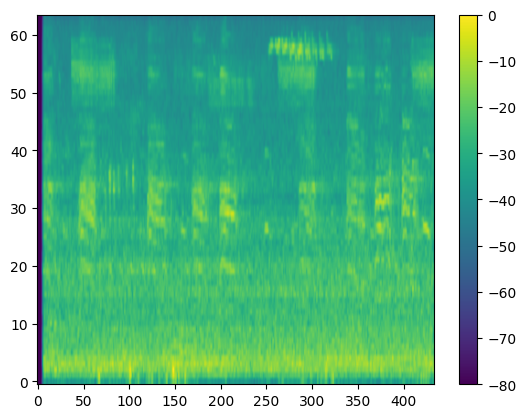

In [4]:
# load an example audio file, converting the data to mel spectrogram

# examplefkey = '1d94fc4a-1c63-4da0-9cac'
#example_audio, sr = librosa.load("%s/%s.wav" % (audiofilefolder, examplefkey), sr=22050)

example_audio, sr = librosa.load(audio_example_path, sr=22050)
example = librosa.feature.melspectrogram(y=example_audio, sr=sr, n_mels=64)

# player
import IPython.display as ipd
audio_element_url = ipd.Audio(example_audio, rate=sr)
ipd.display(audio_element_url)


# Let's look at the spectrogram of one example
plt.imshow(librosa.power_to_db(example, ref=np.max), aspect='auto', origin='lower')
plt.colorbar()

In [5]:
print(example.shape)

(64, 434)


Let's annotate this audio clip in detail, specifying for each *frame* whether it has any bird call active or not.

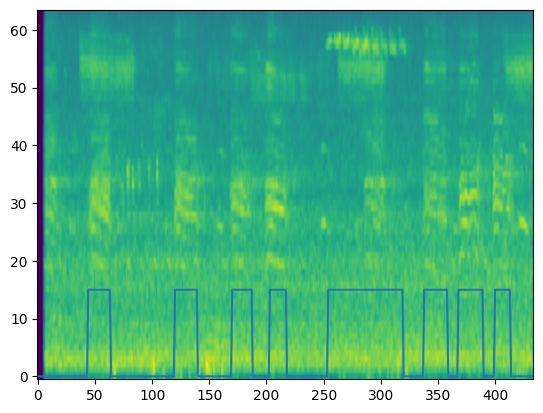

In [6]:
annotation = np.zeros(434)
for onset, offset in [
    (44, 64),
    (120, 140),
    (170, 188),
    (203, 218),
    (254, 320),
    (338, 359),
    (368, 390),
    (400, 414),
                     ]:
    annotation[onset:offset] = 1
    
plt.imshow(librosa.power_to_db(example, ref=np.max), aspect='auto', origin='lower')
plt.plot(annotation*15)

Next we want to establish if there is any *linear* relationship between the energy in the frequency bands, and the regressor (the "independent variable") which is our annotation.

Mean energy when activity is 0: 0.643357
Mean energy when activity is 1: 8.5357


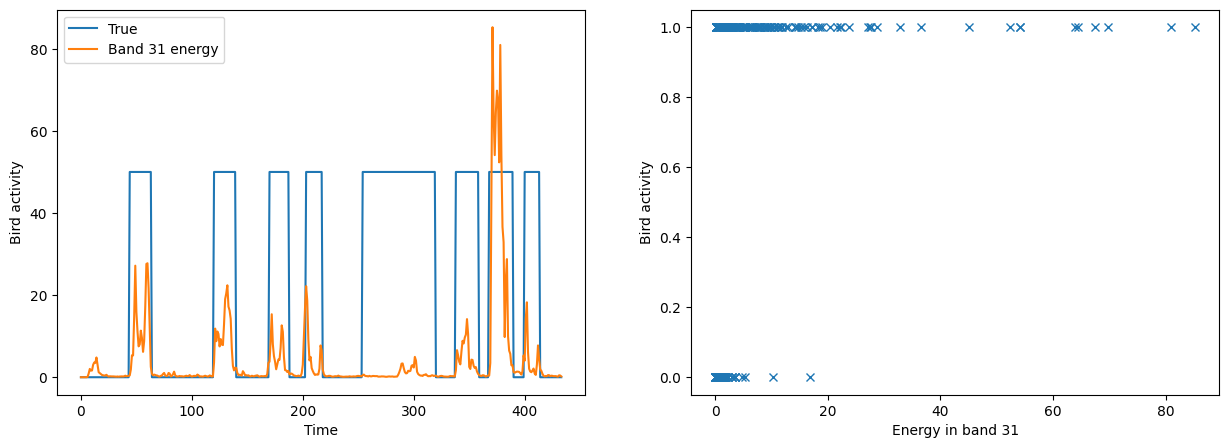

In [7]:
# As a simple example, here's a scatter plot of the energy in frequency band index "31" and our annotation.
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[1].plot(example[31,:], annotation, 'x')
ax[1].set_xlabel("Energy in band 31")
ax[1].set_ylabel("Bird activity")

ax[0].plot(annotation * 50, label="True")
ax[0].plot(example[31,:], label="Band 31 energy")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Bird activity")
ax[0].legend()


print("Mean energy when activity is 0: %g" % np.mean(example[31, np.nonzero(annotation==0)]))
print("Mean energy when activity is 1: %g" % np.mean(example[31, np.nonzero(annotation==1)]))

In [8]:
# Let's set this problem up within the Torch framework:
class LinearRegress(nn.Module):
    def __init__(self, nfreqs):
        super(LinearRegress, self).__init__()
        self.beta = nn.Parameter(torch.randn((nfreqs,1)).abs() * 1e-4)
        self.offset = nn.Parameter(torch.rand((nfreqs,1)) * 1e-4)

    def forward(self, x):
        "Project the data through the coefficients"
        return torch.sum(x * self.beta + self.offset, dim=-2)
    
    def forward_and_convert(self, x):
        "Handles the torch<--->numpy tensor conversion, for convenience"
        x_torch = torch.DoubleTensor(x)
        y_torch = self.forward(x_torch)
        return y_torch.detach().numpy()

Text(0.5, 1.0, 'Linear regression as bird detector - BEFORE fitting')

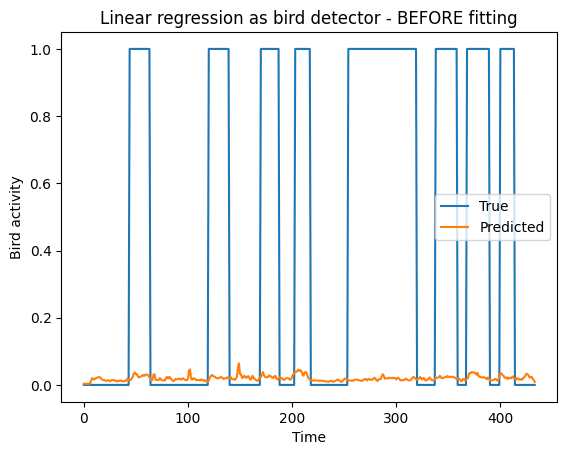

In [9]:
net = LinearRegress(64)
# our network is currently RANDOMLY initialised. What happens when we project our audio through it?
plt.plot(annotation, label="True")
plt.plot(net.forward_and_convert(example), label="Predicted")
plt.xlabel("Time")
plt.ylabel("Bird activity")
plt.legend()
plt.title("Linear regression as bird detector - BEFORE fitting")

In [10]:
# define a loss function and an optimiser
criterion = nn.MSELoss()   # mean-squared error, closely related to Euclidean loss
optimizer = torch.optim.SGD(net.parameters(), lr=0.0000001, momentum=0.8)

In [11]:
# train the network
num_epochs = 10000
annot_torch = torch.DoubleTensor(annotation)
for epoch in range(num_epochs):

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(torch.DoubleTensor(example))
    loss = criterion(annot_torch, outputs)
    
    loss.backward()
    optimizer.step()

    running_loss = loss.item()
    if ((epoch & (epoch - 1)) == 0) or epoch==(num_epochs-1): # don't print on all epochs
        # print statistics
        print('[%d] loss: %.8f' %
            (epoch, running_loss))

example_result = outputs.detach().numpy()
print('Finished Training')

[0] loss: 0.43145938
[1] loss: 0.43126067
[2] loss: 0.43090345
[4] loss: 0.42983701
[8] loss: 0.42686894
[16] loss: 0.41979618
[32] loss: 0.40574150
[64] loss: 0.38141026
[128] loss: 0.34490422
[256] loss: 0.30078988
[512] loss: 0.25880043
[1024] loss: 0.22298965
[2048] loss: 0.19509913
[4096] loss: 0.17245362
[8192] loss: 0.15193539
[9999] loss: 0.14645893
Finished Training


Text(0.5, 1.0, 'Linear regression as bird detector')

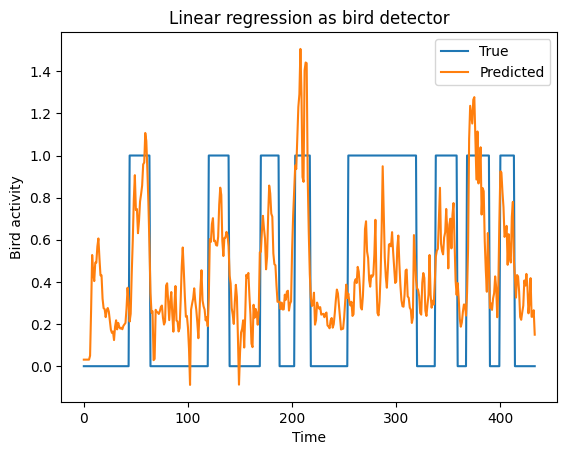

In [12]:
plt.plot(annotation, label="True")
plt.plot(net.forward_and_convert(example), label="Predicted")
plt.xlabel("Time")
plt.ylabel("Bird activity")
plt.legend()
plt.title("Linear regression as bird detector")

Text(0.5, 1.0, 'Scatter plot')

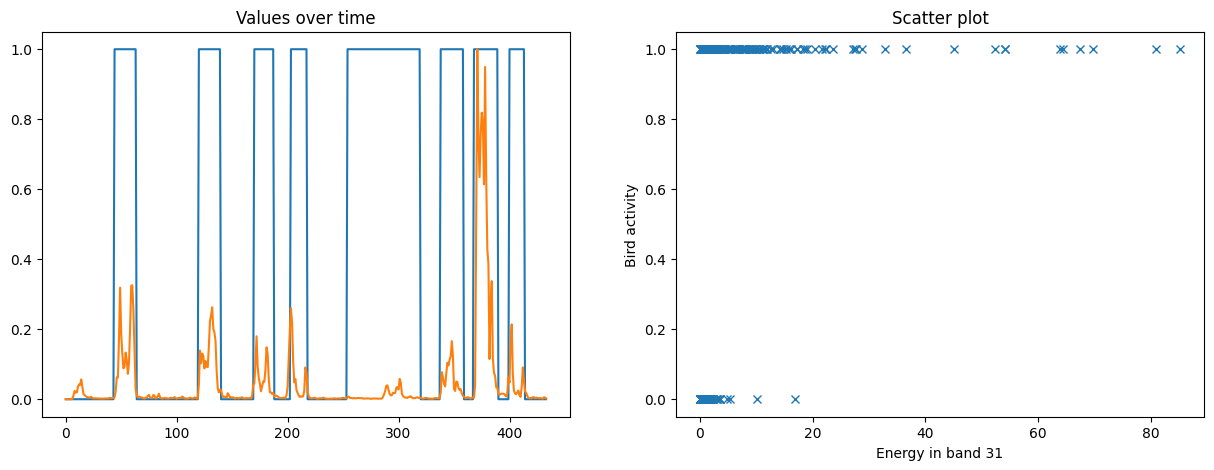

In [13]:
### Let's compare the linear regression predictions against our "energy in band 31" scatter
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Linear regression as bird detector
ax[0].plot(annotation)
ax[0].plot(example[31,:] / example[31,:].max())
ax[0].set_title("Values over time")

# Scatter plot. Is there a correlation?
ax[1].plot(example[31,:], annotation, 'x')
ax[1].set_xlabel("Energy in band 31")
ax[1].set_ylabel("Bird activity")
ax[1].set_title("Scatter plot")

Text(0.5, 0, 'Frequency')

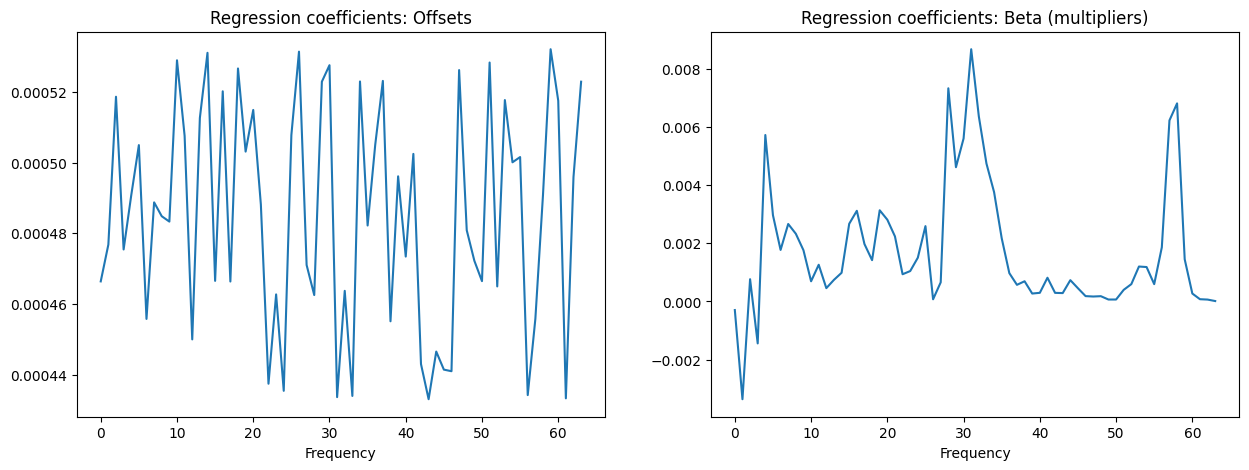

In [14]:
# Let's inspect the parameters
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(net.offset.detach().numpy())
ax[0].set_title("Regression coefficients: Offsets")
ax[0].set_xlabel("Frequency")

ax[1].plot(net.beta.detach().numpy())
ax[1].set_title("Regression coefficients: Beta (multipliers)")
ax[1].set_xlabel("Frequency")

Exercise:
-------

* Convert the code above from a linear regression to a *logistic* regression. Retrain it and inspect how well it can do. Is it better?

In [15]:
# Your code here

# This is almost exactly copied-and-pasted from my "LinearRegress" module above
#   except I added the torch.sigmoid nonlinearity
import torch
from torch import nn
from torch.nn.functional import sigmoid
class LogisticRegress(nn.Module):
    def __init__(self, nfreqs):
        super(LogisticRegress, self).__init__()
        self.beta = nn.Parameter(torch.randn((nfreqs,1)).abs() * 1e-4)
        self.offset = nn.Parameter(torch.rand((nfreqs,1)) * 1e-4)

    def forward(self, x):
        "Project the data through the coefficients"
        return sigmoid(torch.sum(x * self.beta + self.offset, dim=-2))
    
    def forward_and_convert(self, x):
        "Handles the torch<--->numpy tensor conversion, for convenience"
        x_torch = torch.DoubleTensor(x)
        y_torch = self.forward(x_torch)
        return y_torch.detach().numpy()

Text(0.5, 1.0, 'Logistic regression as bird detector - BEFORE fitting')

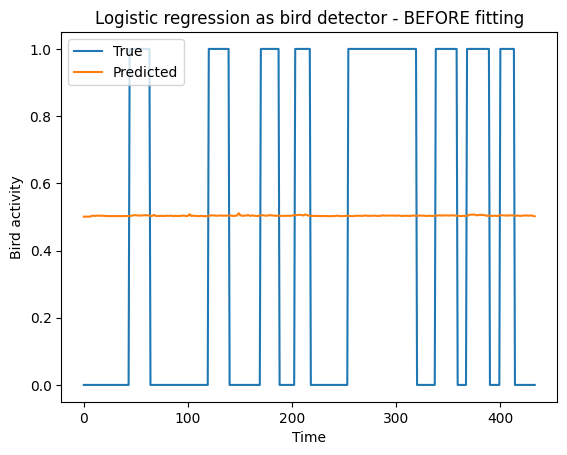

In [16]:
net = LogisticRegress(64)
# our network is currently RANDOMLY initialised. What happens when we project our audio through it?
plt.plot(annotation, label="True")
plt.plot(net.forward_and_convert(example), label="Predicted")
plt.xlabel("Time")
plt.ylabel("Bird activity")
plt.legend()
plt.title("Logistic regression as bird detector - BEFORE fitting")

In [17]:
# define a loss function and an optimiser
criterion = nn.MSELoss()   # mean-squared error, closely related to Euclidean loss
# ...MSE is not necessarily the best loss to use
optimizer = torch.optim.SGD(net.parameters(), lr=0.00001, momentum=0.8)

In [18]:
# train the network
num_epochs = 10000
annot_torch = torch.DoubleTensor(annotation)
for epoch in range(num_epochs):

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(torch.DoubleTensor(example))
    loss = criterion(annot_torch, outputs)
    
    loss.backward()
    optimizer.step()

    running_loss = loss.item()
    if ((epoch & (epoch - 1)) == 0) or epoch==(num_epochs-1): # don't print on all epochs
        # print statistics
        print('[%d] loss: %.8f' %
            (epoch, running_loss))

example_result = outputs.detach().numpy()
print('Finished Training')

[0] loss: 0.24987849
[1] loss: 0.24978947
[2] loss: 0.24963000
[4] loss: 0.24915853
[8] loss: 0.24788579
[16] loss: 0.24510432
[32] loss: 0.24042023
[64] loss: 0.23328960
[128] loss: 0.22239228
[256] loss: 0.20731351
[512] loss: 0.18944563
[1024] loss: 0.17057076
[2048] loss: 0.15164107
[4096] loss: 0.13358040
[8192] loss: 0.11651822
[9999] loss: 0.11168695
Finished Training


Text(0.5, 1.0, 'Logistic regression (trained) as bird detector')

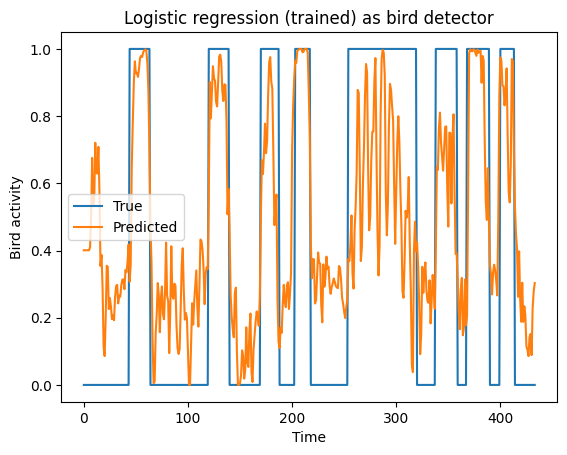

In [19]:
plt.plot(annotation, label="True")
plt.plot(net.forward_and_convert(example), label="Predicted")
plt.xlabel("Time")
plt.ylabel("Bird activity")
plt.legend()
plt.title("Logistic regression (trained) as bird detector")

4b: batch training, machine learning
----

Now, instead of working on one file all at once, convert the code so that it iterates over it in "batches" -- this is analogous to the way deep learning is trained. We will use chunks of 10 spectrogram columns at once, rather than the whole example file. Here is the loader function for you to use:

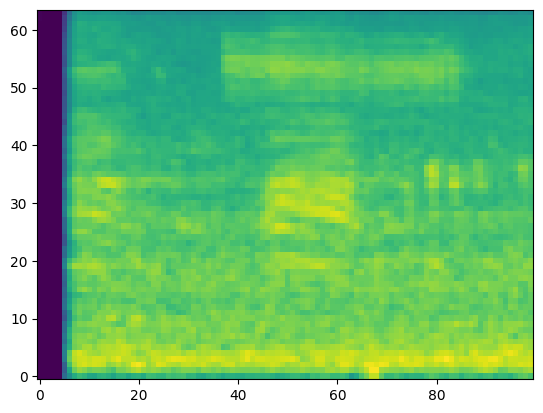

In [20]:
chunksize = 100
def get_chunk_of_specgram(specgram, idx):
    startpos = chunksize * idx
    endpos = chunksize * (idx+1)
    if endpos > specgram.shape[1]:
        raise ValueError(f"index {idx} is beyond the end of the supplied spectrogram")
    return specgram[:, startpos:endpos]

def get_chunk_of_annotation(annotation, idx):
    startpos = chunksize * idx
    endpos = chunksize * (idx+1)
    if endpos > annotation.shape[0]:
        raise ValueError(f"index {idx} is beyond the end of the supplied annotation")
    return annotation[startpos:endpos]

onechunk = get_chunk_of_specgram(example, 0)
plt.imshow(librosa.power_to_db(onechunk, ref=np.max), aspect='auto', origin='lower')


Use the PyTorch "Dataset" class to iterate over these (see last week's example, or other online examples). You don't need to create a whole new neural net in PyTorch (you can use the one we created above), but the PyTorch "Dataset" class separately is useful.


In [21]:
from torch.utils.data import DataLoader, Dataset
import lightning.pytorch as pl
import os
from math import floor

class AudioChunkDataset(Dataset):
    """This dataset uses a single fixed spectrogram in memory,
    and uses get_chunk_of_specgram() to divide it into chunks."""
    
    # Your code here
    
    def __init__(self, specgram, annotation, chunksize):
        self.specgram = specgram
        self.annotation = annotation
        self.chunksize = chunksize
    
    def __len__(self):
        # we can measure how many chunks we'll produce
        return int(floor(len(self.annotation)/self.chunksize))

    def __getitem__(self, idx):
        try:
            X = get_chunk_of_specgram(self.specgram, idx).astype("float64")
            y = get_chunk_of_annotation(self.annotation, idx)
        except ValueError:
            raise StopIteration
        return (X, y)

# Let's see if it works -- we just iterate through and print out each item
try_this_dataset = AudioChunkDataset(example, annotation, chunksize)
print(f"Dataset now has {len(try_this_dataset)} chunks")
for idx, x in enumerate(try_this_dataset):
    print(f"Item {idx}:", x[0].shape, x[0].dtype, x[1])

Dataset now has 4 chunks
Item 0: (64, 100) float64 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Item 1: (64, 100) float64 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Item 2: (64, 100) float64 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

Text(0.5, 1.0, 'Logistic regression as bird detector - BEFORE fitting')

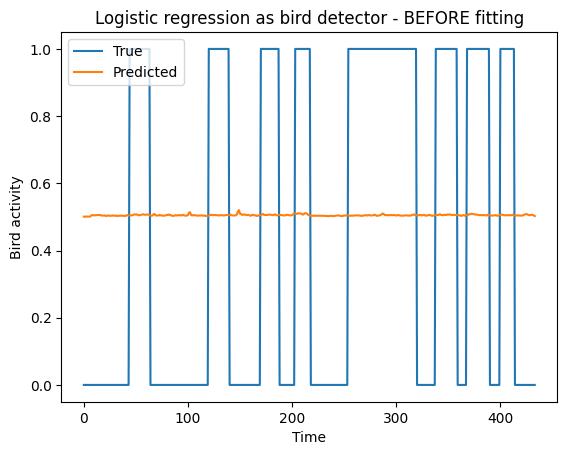

In [22]:
net = LogisticRegress(64)
# our network is currently RANDOMLY initialised. What happens when we project our audio through it?
plt.plot(annotation, label="True")
plt.plot(net.forward_and_convert(example), label="Predicted")
plt.xlabel("Time")
plt.ylabel("Bird activity")
plt.legend()
plt.title("Logistic regression as bird detector - BEFORE fitting")

In [23]:
# define a loss function and an optimiser
criterion = nn.MSELoss()   # mean-squared error, closely related to Euclidean loss
# ...MSE is not necessarily the best loss to use
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.8)

In [24]:
# train the network
num_epochs = 10000
annot_torch = torch.DoubleTensor(annotation)

# NB here we're using the new "Dataset" class
dataloader = DataLoader(AudioChunkDataset(example, annotation, chunksize), batch_size=2, shuffle=True)

for epoch in range(num_epochs):

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    for X, y in dataloader:
        outputs = net(torch.DoubleTensor(X))
        #print(f"Shapes: X {X.shape}, y {y.shape}, outputs {outputs.shape}")
        loss = criterion(y, outputs)

        loss.backward()
        optimizer.step()

    running_loss = loss.item()
    if ((epoch & (epoch - 1)) == 0) or epoch==(num_epochs-1): # don't print on all epochs
        # print statistics
        print('[%d] loss: %.8f' %
            (epoch, running_loss))

example_result = outputs.detach().numpy()
print('Finished Training')

[0] loss: 0.22123991
[1] loss: 0.21134869
[2] loss: 0.15637206
[4] loss: 0.23766355
[8] loss: 0.22117870
[16] loss: 0.08070864
[32] loss: 0.11356535
[64] loss: 0.06457154
[128] loss: 0.06157156
[256] loss: 0.02043720
[512] loss: 0.02548567
[1024] loss: 0.02396932
[2048] loss: 0.05029750
[4096] loss: 0.04506558
[8192] loss: 0.02741927
[9999] loss: 0.02484512
Finished Training


Text(0.5, 1.0, 'Logistic regression (trained in batches) as bird detector')

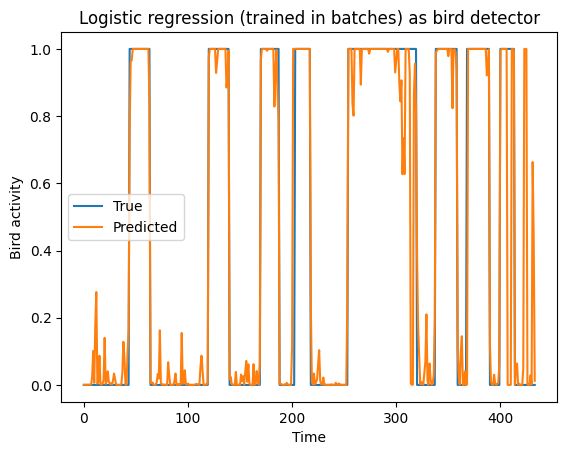

In [25]:
plt.plot(annotation, label="True")
plt.plot(net.forward_and_convert(example), label="Predicted")
plt.xlabel("Time")
plt.ylabel("Bird activity")
plt.legend()
plt.title("Logistic regression (trained in batches) as bird detector")

If you can set this up so that it trains, you should be able to train it until convergence, just like in the first part of the lab. But the results might not be the same. Why would this be?

Your answer here (text):

In the first part, all of the data was seen "at once" by the algorithm, and a single update to its parameters. In this version, the update is broken down into smaller steps, and the parameters are updated incrementally. For example, the parameters may change even after only the first chunk has been evaluated. Thus, the progress of training can be very different.